In [1]:
"""
k个GPU并行训练：
小批量样本都将被分为k个部分，并均匀地分配到GPU上
将k个GPU的局部梯度聚合，获得当前小批量的随机梯度
聚合梯度被重新分发到每个GPU
每个GPU使用这个小批量随机梯度，更新它所维护的完整的模型参数集
"""
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
scale = .01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))

    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)

    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)

    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

loss = nn.CrossEntropyLoss(reduction='none')

In [3]:
def get_params(params, device):
    """ 将params放到device上，并求梯度 """
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

In [4]:
new_params = get_params(params, d2l.try_gpu(0))
print(f'b1权重：{new_params[1]}\n')
print(f'b1梯度：{new_params[1].grad}\n')

b1权重：tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)

b1梯度：None



In [13]:
def allreduce(data):
    """ data由每个GPU上的数据组成\n 
    将所有向量相加，并将结果广播给所有GPU"""
    for i in range(1, len(data)):   # 将所有向量相加
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):   # 将结果广播给所有GPU
        data[i][:] = data[0].to(data[i].device)

In [15]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print(f'allreduce前：\n{data[0]}\n{data[1]}')
allreduce(data)
print(f'allreduce前：\n{data[0]}\n{data[1]}')

allreduce前：
tensor([[1., 1.]], device='cuda:0')
tensor([[2., 2.]])
allreduce前：
tensor([[3., 3.]], device='cuda:0')
tensor([[3., 3.]])


In [20]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:0')]
split = nn.parallel.scatter(data, devices)  # 将数据分均匀分到devices上
print('input:', data)
print(f'load into:{devices}')
print(f'output:{split}')    # 看结果，似乎也模仿出了两个GPU设备

input: tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into:[device(type='cuda', index=0), device(type='cuda', index=0)]
output:(tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:0'))


In [21]:
def split_batch(X, y, devices):
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices), nn.parallel.scatter(y, devices))

In [22]:
def train_batch(X, y, device_params, devices, lr):
    """ device_params：各GPU上的权重/偏置参数\n
    每个batch分到所有GPU上训练并计算梯度 """
    X_shards, y_shards = split_batch(X, y, devices)
    ls = [loss(lenet(x_shard, device_w), y_shard).sum() for x_shard, y_shard, device_w in zip(X_shards, y_shards, device_params)]
    for l in ls:
        l.backward()    # 每个GPU上反向传播
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])  # 所有梯度相加到某一GPU，并广播给所有GPU
    for param in device_params:     # 在每个GPU上
        d2l.sgd(param, lr, X.shape[0])  # 更新模型参数

In [26]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]
        ), ))
    print(f'测试精度:{animator.Y[0][-1]:.2f}, {timer.avg():.1f}sec/epoch, on {str(devices)}')

测试精度:0.83, 8.7sec/epoch, on [device(type='cuda', index=0)]


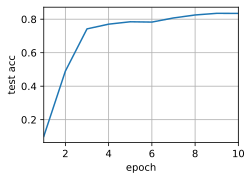

In [27]:
train(num_gpus=1, batch_size=256, lr=.2)

ValueError: Expected a non cpu device, but got: cpu

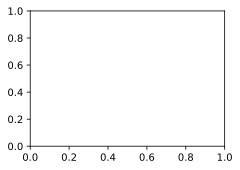

In [28]:
train(num_gpus=2, batch_size=256, lr=.2)